In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot
import igraph
import scvelo as scv 
import loompy as lmp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix 
import os 

In [2]:
sc.set_figure_params(facecolor= 'white', figsize= (8,8))
sc.settings.verbosity =3

In [4]:
adata_spatial_anterior= sc.datasets.visium_sge(sample_id= "V1_Mouse_Brain_Sagittal_Anterior")
adata_spatial_anterior.var_names_make_unique()

reading C:\Users\skeam\OneDrive - Inside MD Anderson\Genetic and genomic work__python workflow\Single cell project with python___\data\V1_Mouse_Brain_Sagittal_Anterior\filtered_feature_bc_matrix.h5
 (0:00:00)


In [5]:
# QC and preprocessing 
adata_spatial_anterior.var["mt"]= adata_spatial_anterior.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_spatial_anterior, qc_vars= ["mt"], inplace= True)

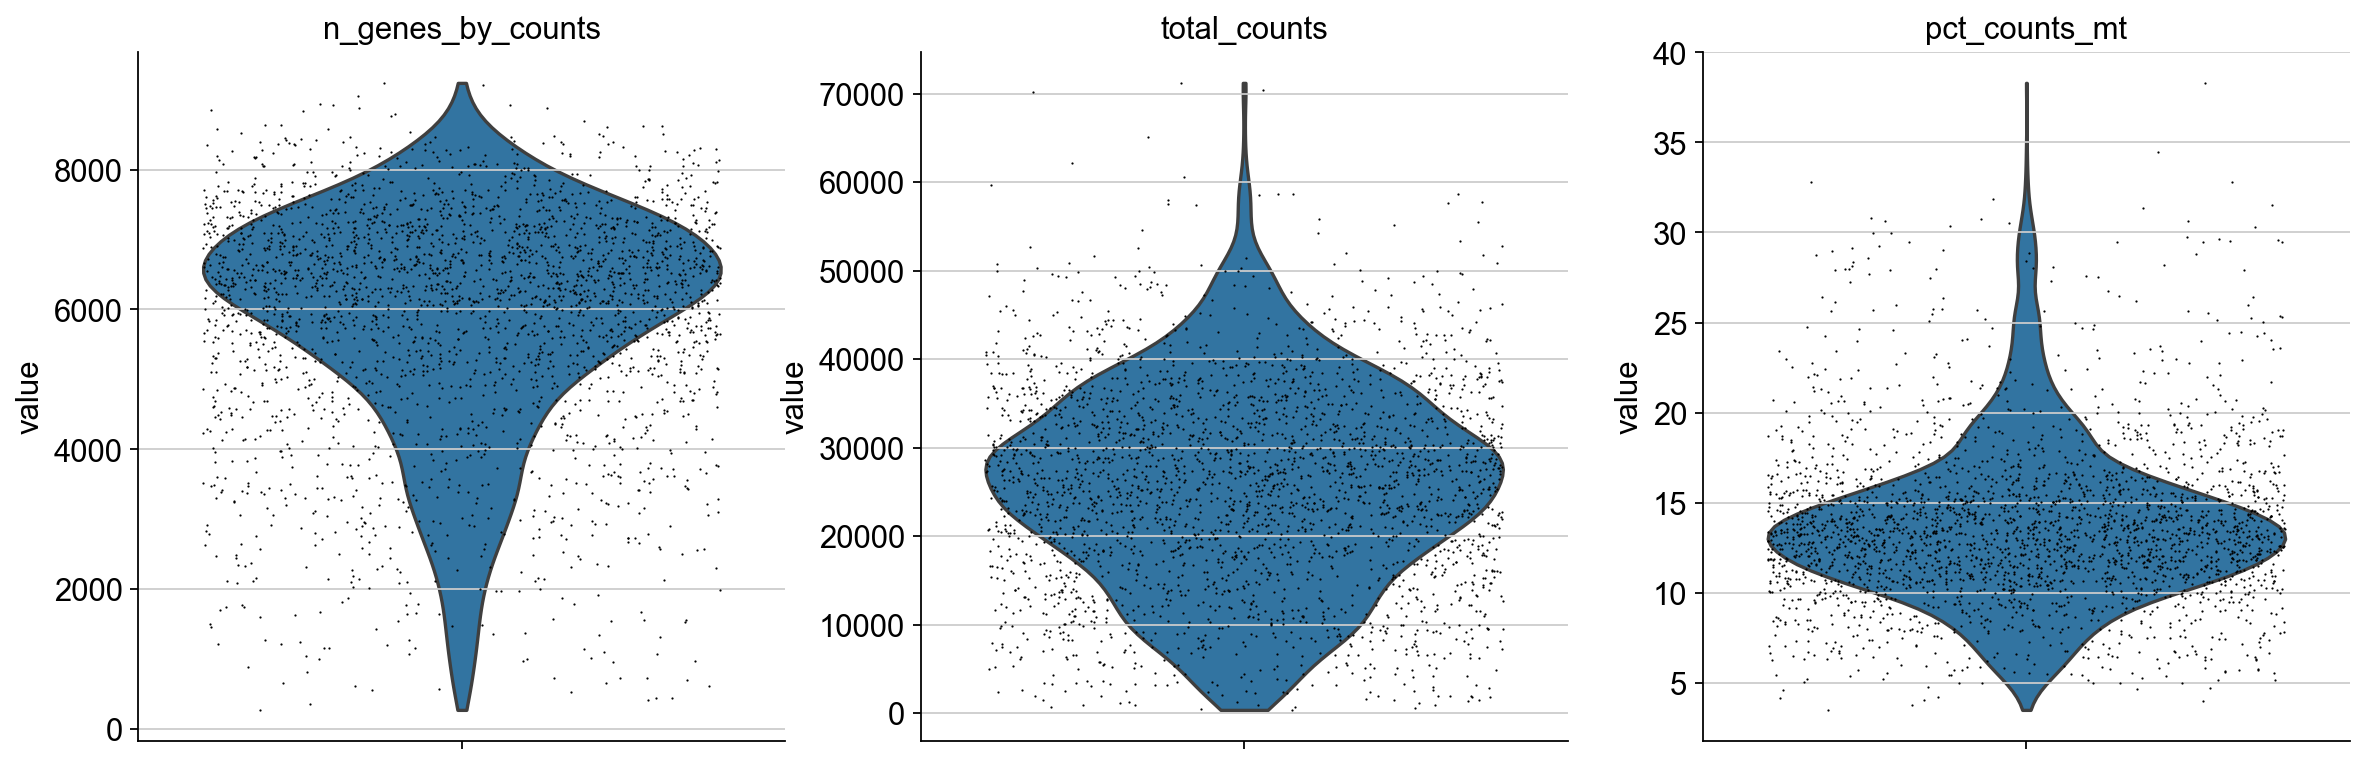

In [6]:
sc.pl.violin(adata_spatial_anterior, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
            jitter= 0.4, multi_panel= True)

In [7]:
adata_spatial_anterior= adata_spatial_anterior[adata_spatial_anterior.obs.n_genes_by_counts> 2000, :]
adata_spatial_anterior= adata_spatial_anterior[adata_spatial_anterior.obs.total_counts< 50000, :]
adata_spatial_anterior= adata_spatial_anterior[adata_spatial_anterior.obs.total_counts> 5000, :]
adata_spatial_anterior= adata_spatial_anterior[adata_spatial_anterior.obs.pct_counts_mt < 25, :]
sc.pp.filter_genes(adata_spatial_anterior, min_cells= 10)

filtered out 15250 genes that are detected in less than 10 cells


In [8]:
adata_spatial_posterior= sc.datasets.visium_sge(sample_id= "V1_Mouse_Brain_Sagittal_Posterior")
adata_spatial_posterior.var_names_make_unique()

  0%|          | 0.00/9.26M [00:00<?, ?B/s]

  0%|          | 0.00/20.1M [00:00<?, ?B/s]

reading C:\Users\skeam\OneDrive - Inside MD Anderson\Genetic and genomic work__python workflow\Single cell project with python___\data\V1_Mouse_Brain_Sagittal_Posterior\filtered_feature_bc_matrix.h5
 (0:00:00)


In [9]:
# QC and preprocessing 
adata_spatial_posterior.var["mt"]= adata_spatial_posterior.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_spatial_posterior, qc_vars= ["mt"], inplace= True)

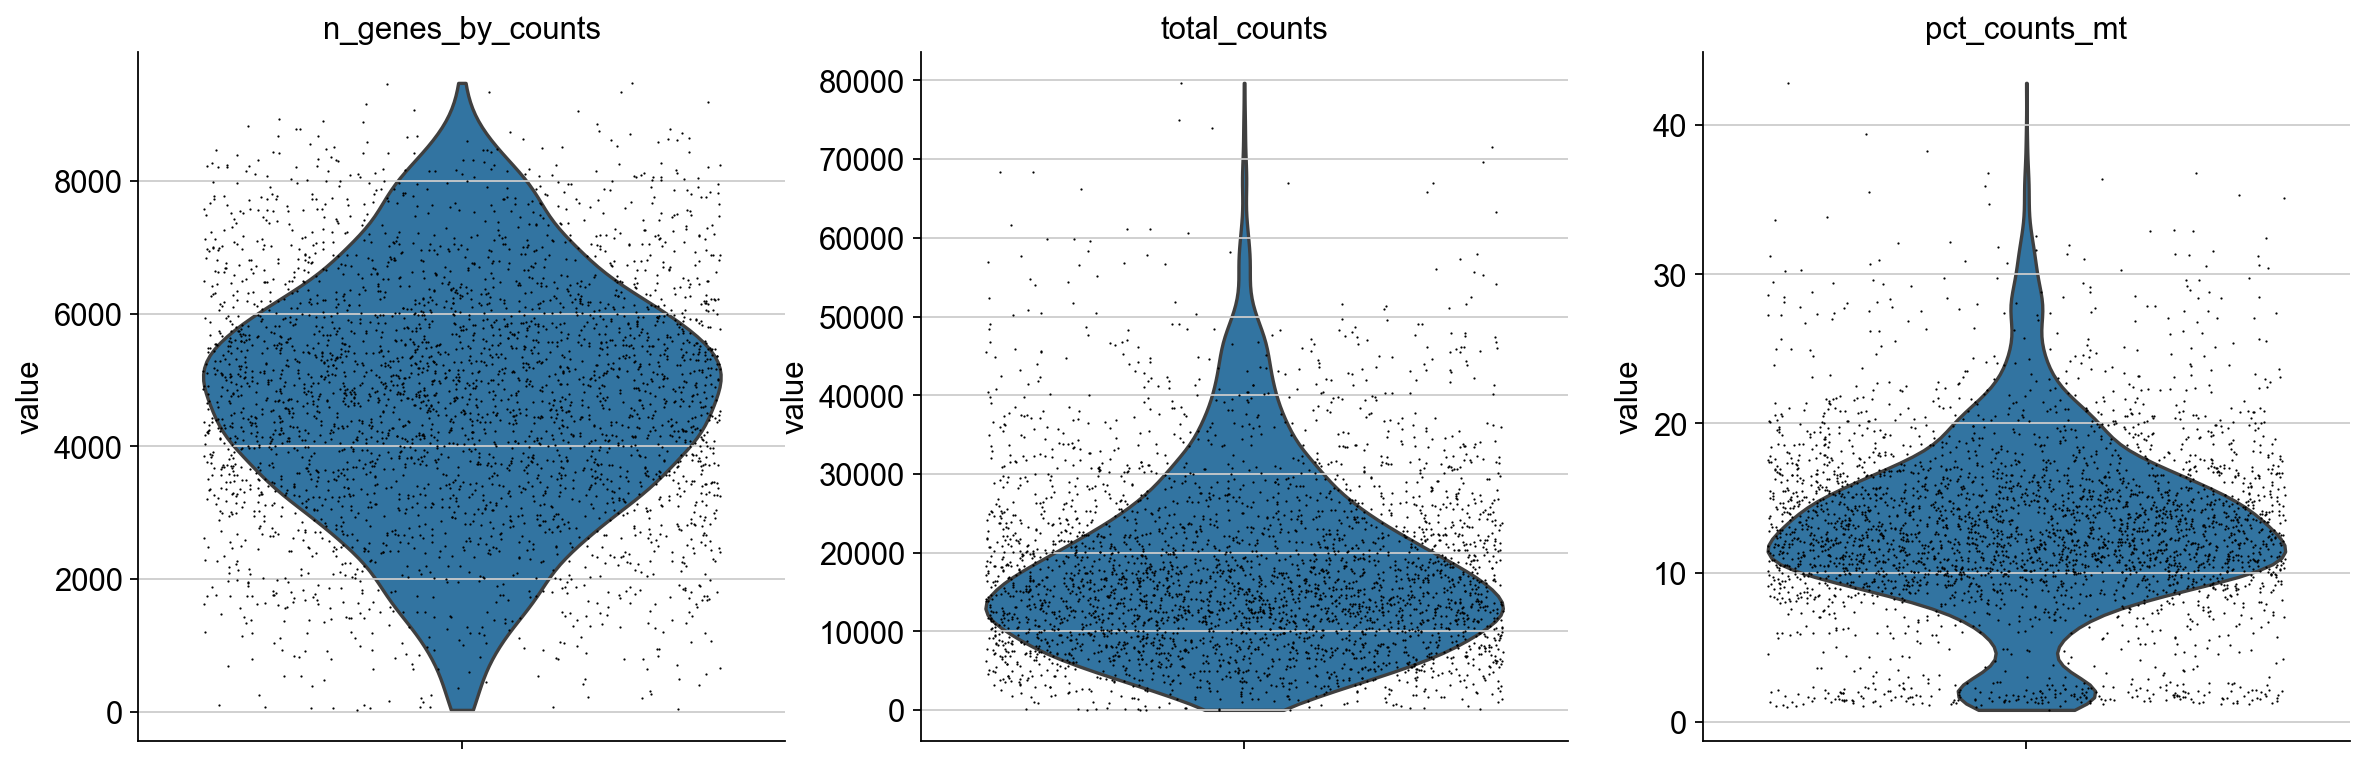

In [10]:
sc.pl.violin(adata_spatial_posterior, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
            jitter= 0.4, multi_panel= True)

In [11]:
adata_spatial_posterior= adata_spatial_posterior[adata_spatial_posterior.obs.n_genes_by_counts> 2000, :]
adata_spatial_posterior= adata_spatial_posterior[adata_spatial_posterior.obs.total_counts< 50000, :]
adata_spatial_posterior= adata_spatial_posterior[adata_spatial_posterior.obs.total_counts> 5000, :]
adata_spatial_posterior= adata_spatial_posterior[adata_spatial_posterior.obs.pct_counts_mt < 25, :]
sc.pp.filter_genes(adata_spatial_posterior, min_cells= 10)

filtered out 15320 genes that are detected in less than 10 cells


In [12]:
for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]: 
    sc.pp.normalize_total(adata, inplace= True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor= "seurat", n_top_genes= 2000, inplace= True)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [13]:
#list of dataset 
adatas= [adata_spatial_anterior, adata_spatial_posterior]

In [14]:
adatas

[AnnData object with n_obs × n_vars = 2500 × 17035
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial', 'log1p', 'hvg'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 2908 × 16965
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt

In [15]:
%pip install scanorama


  Obtaining dependency information for scanorama from https://files.pythonhosted.org/packages/36/ec/4077eb780a026f40816d4d64444ed01596a8ee166be53e7995cd0162dc28/scanorama-1.7.4-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for geosketch>=1.0 from https://files.pythonhosted.org/packages/d4/d0/36d76fef1ce6273b2e934cbc27f653a401157d223c1a79d7be2c89066d56/geosketch-1.2-py3-none-any.whl.metadata
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11390 sha256=7bbff8319fa459b84eeed593dc2dd22840d5f2c50223b816b2b053eb668c90a8
  Stored in directory: c:\users\skeam\appdata\local\pip\cache\wheels\71\ae\f7\5b7e1e16a133d094431428169e9a8d9f750afe5459f0333c9b
Successfully built fbpca


In [17]:
import scanorama

In [18]:
#batch correction and gene intersection 
adatas_corrected= scanorama.correct_scanpy(adatas, return_dimred= True)

Found 16486 genes among all datasets
[[0.        0.4411967]
 [0.        0.       ]]
Processing datasets (0, 1)


In [19]:
adatas_corrected

[AnnData object with n_obs × n_vars = 2500 × 16486
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial', 'log1p', 'hvg'
     obsm: 'spatial', 'X_scanorama',
 AnnData object with n_obs × n_vars = 2908 × 16486
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', '

In [20]:
#Integration 
adata_spatial= sc.concat(
    adatas_corrected, 
    label= "library_id", 
    uns_merge= "unique", 
    keys=[
        k 
        for d in [
            adatas_corrected[0].uns["spatial"], 
            adatas_corrected[1].uns["spatial"], 
        ]
        for k, v in d.items()
    ], 
    index_unique= "-",
)

In [21]:
sc.pp.neighbors(adata_spatial, use_rep= "X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added= "clusters", resolution= .2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
running Leiden clustering
    finished: found 10 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


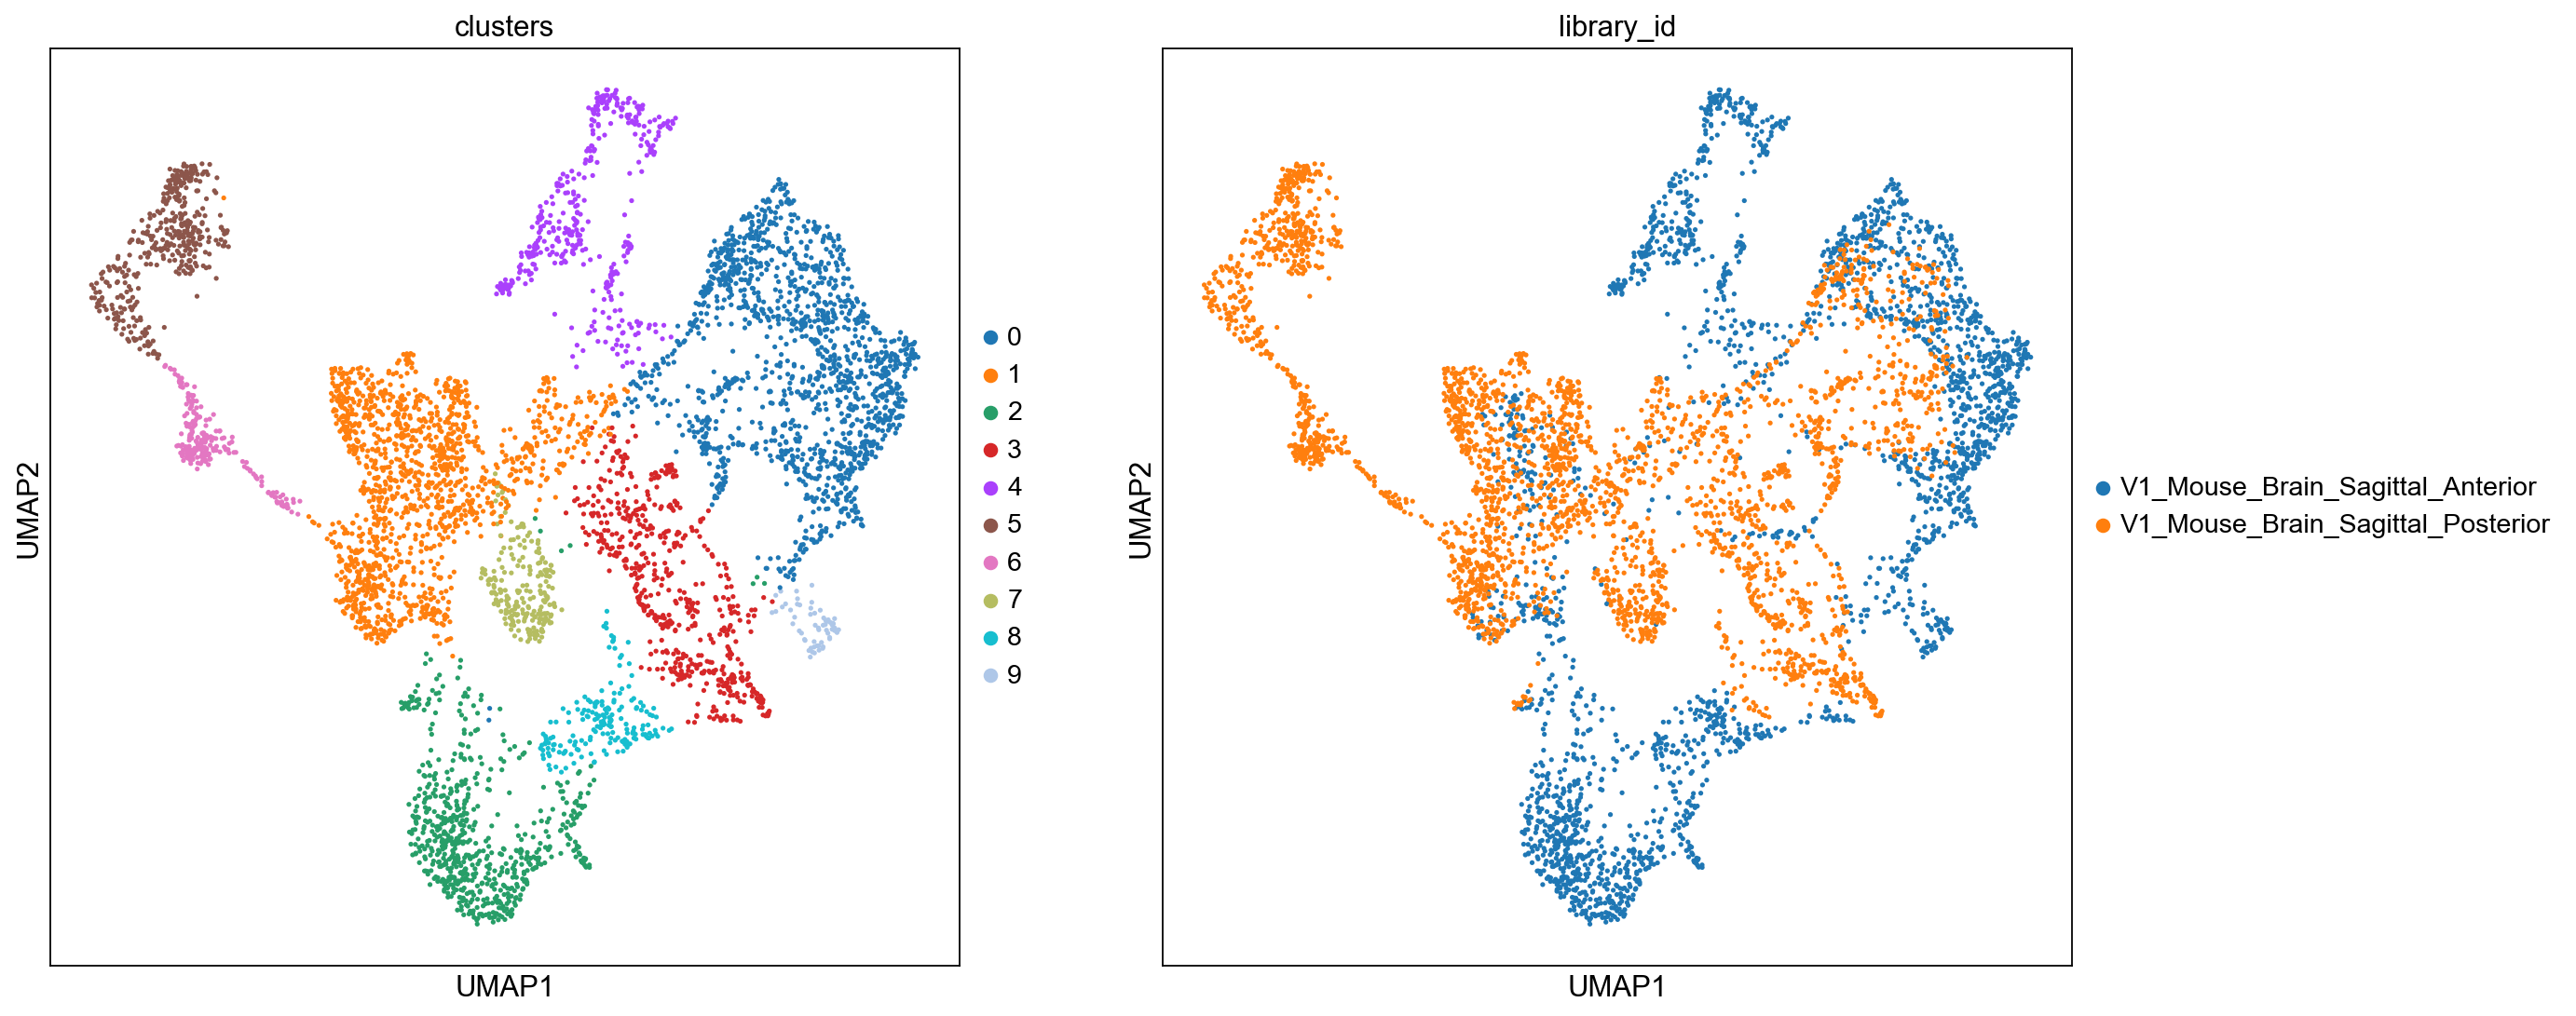

In [22]:
sc.pl.umap(adata_spatial, color= ["clusters", "library_id"], palette= sc.pl.palettes.default_20)

In [23]:
clusters_colors= dict(zip([str(i) for i in range(9)], adata_spatial.uns["clusters_colors"]))

In [24]:
clusters_colors

{'0': '#1f77b4',
 '1': '#ff7f0e',
 '2': '#279e68',
 '3': '#d62728',
 '4': '#aa40fc',
 '5': '#8c564b',
 '6': '#e377c2',
 '7': '#b5bd61',
 '8': '#17becf'}

In [29]:
import matplotlib.pyplot as plt

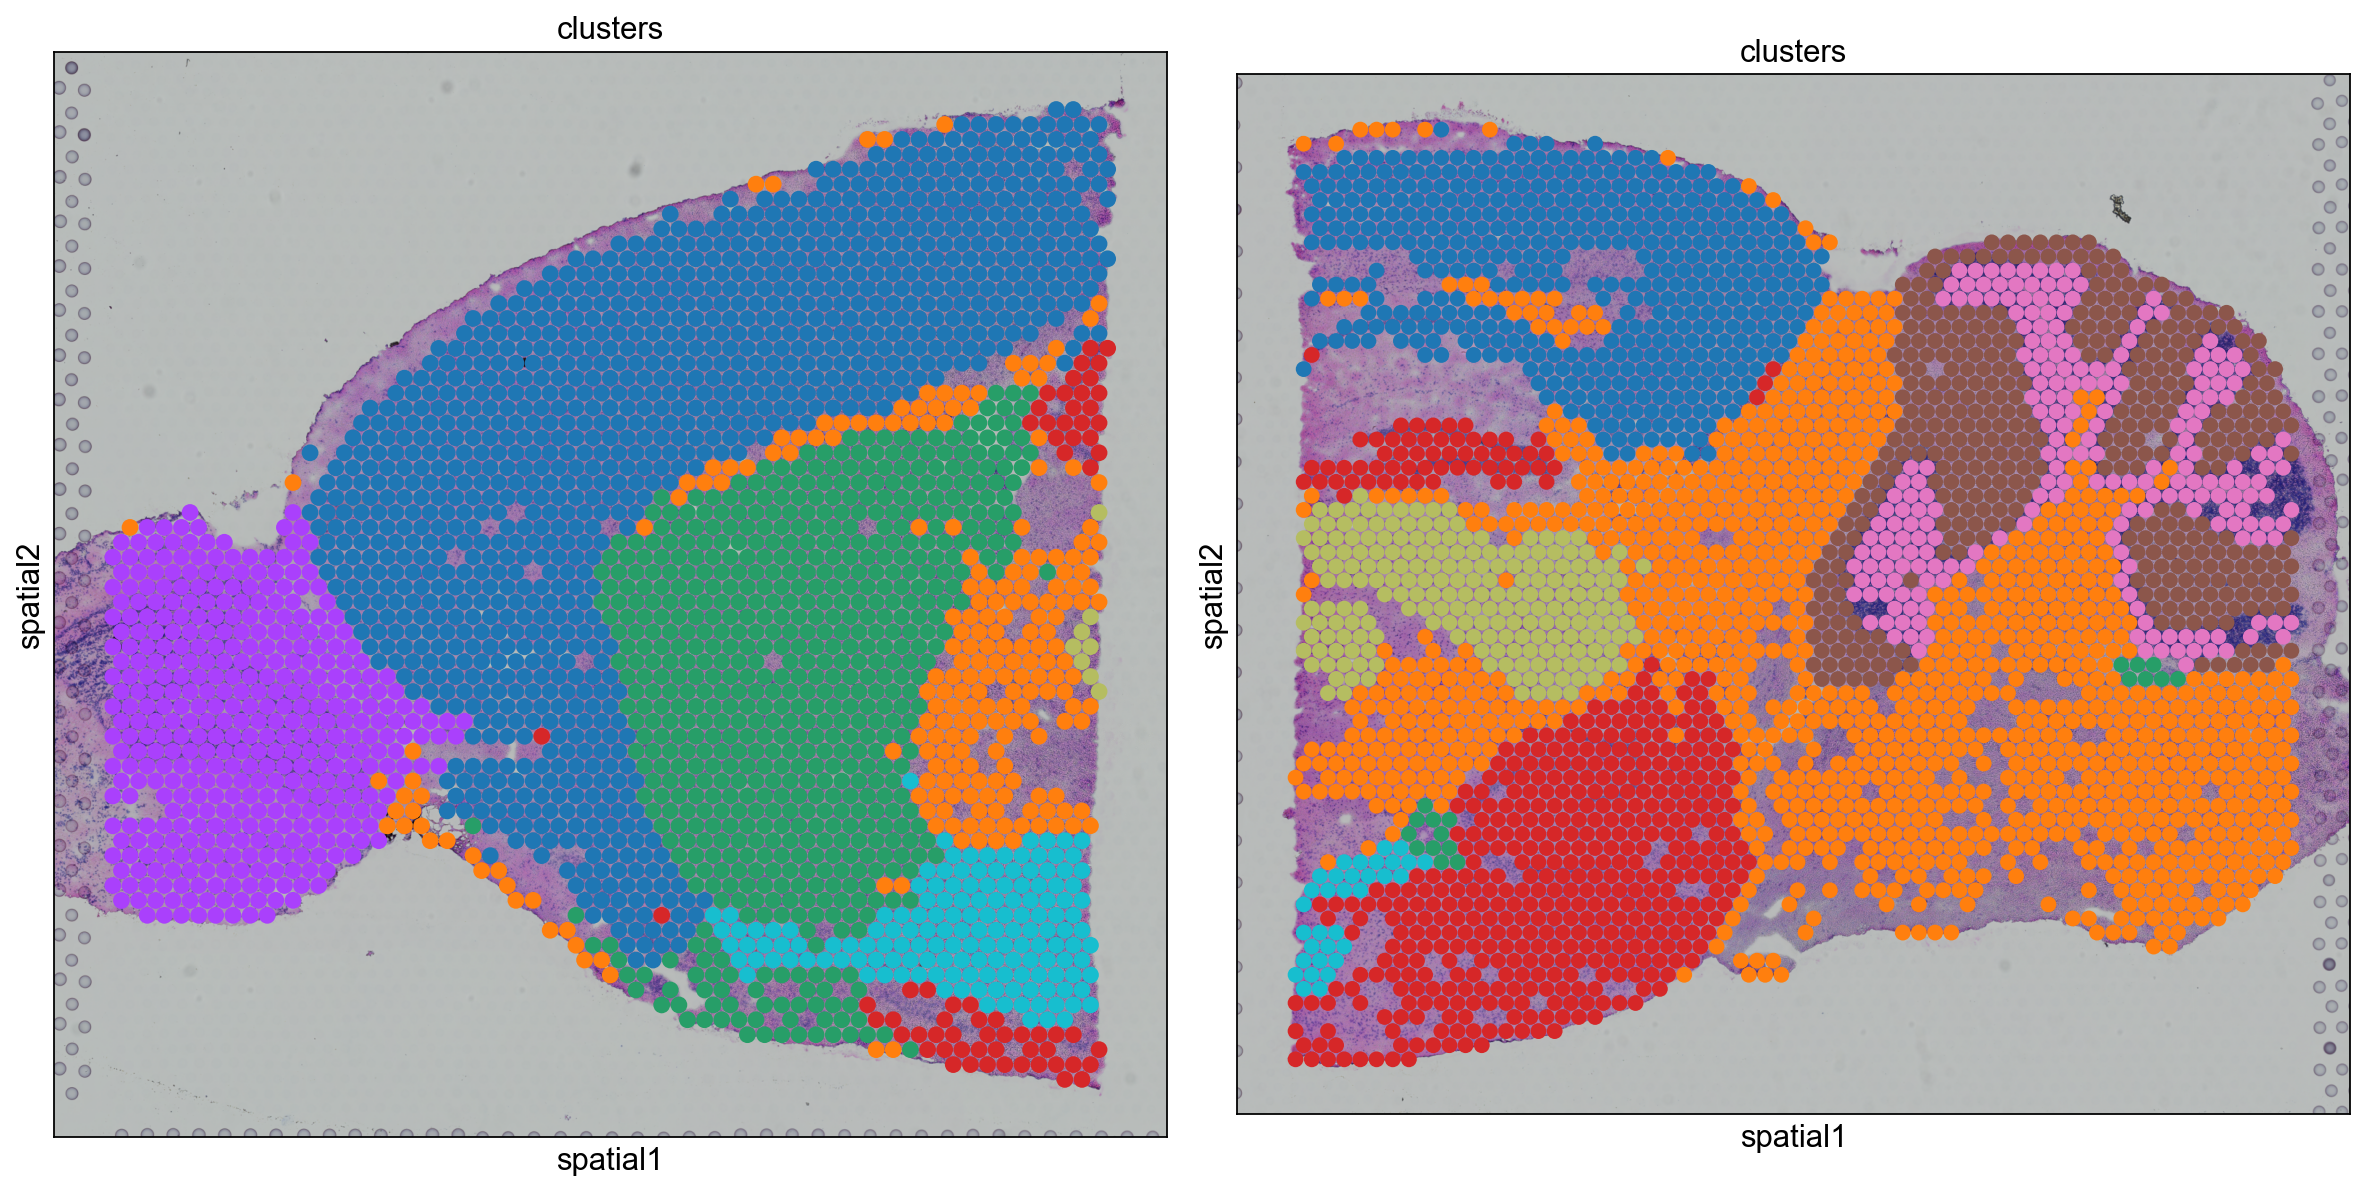

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]):
    ad= adata_spatial[adata_spatial.obs.library_id== library, :].copy()
    sc.pl.spatial(ad, img_key= "hires", library_id= library, color="clusters", size=1.5, 
                 palette= [
                     v
                     for k, v in clusters_colors.items()
                     if k in ad.obs.clusters.unique().tolist()
                 ],
                 legend_loc= None, show= False, ax= axs[i],)
plt.tight_layout()

In [37]:
sc.tl.rank_genes_groups(adata_spatial, "clusters", method= "wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:26)


         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:58)
Storing dendrogram info using `.uns['dendrogram_clusters']`


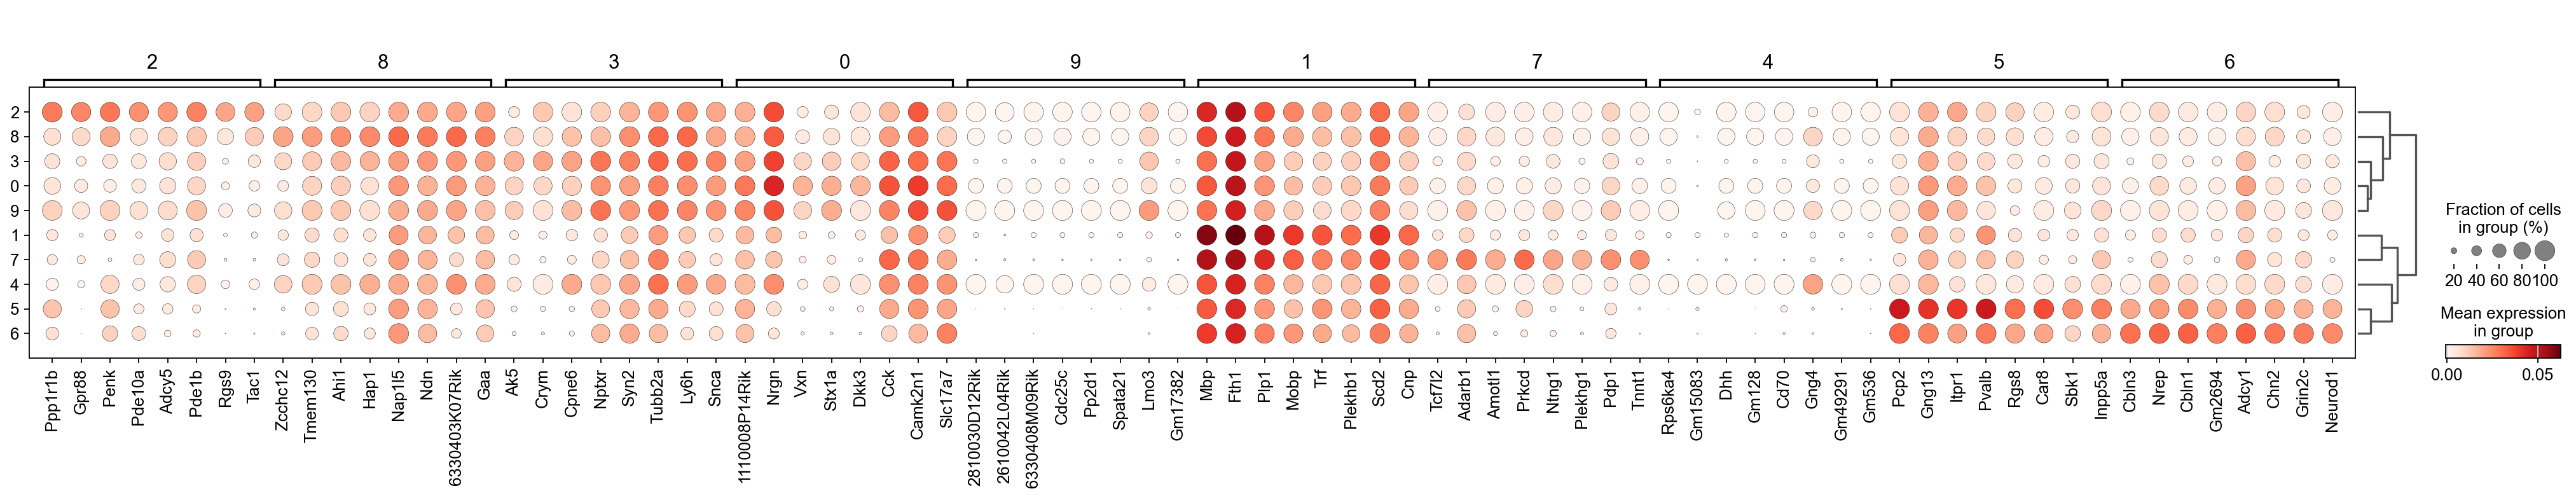

In [38]:
sc.pl.rank_genes_groups_dotplot(adata_spatial, n_genes= 8)

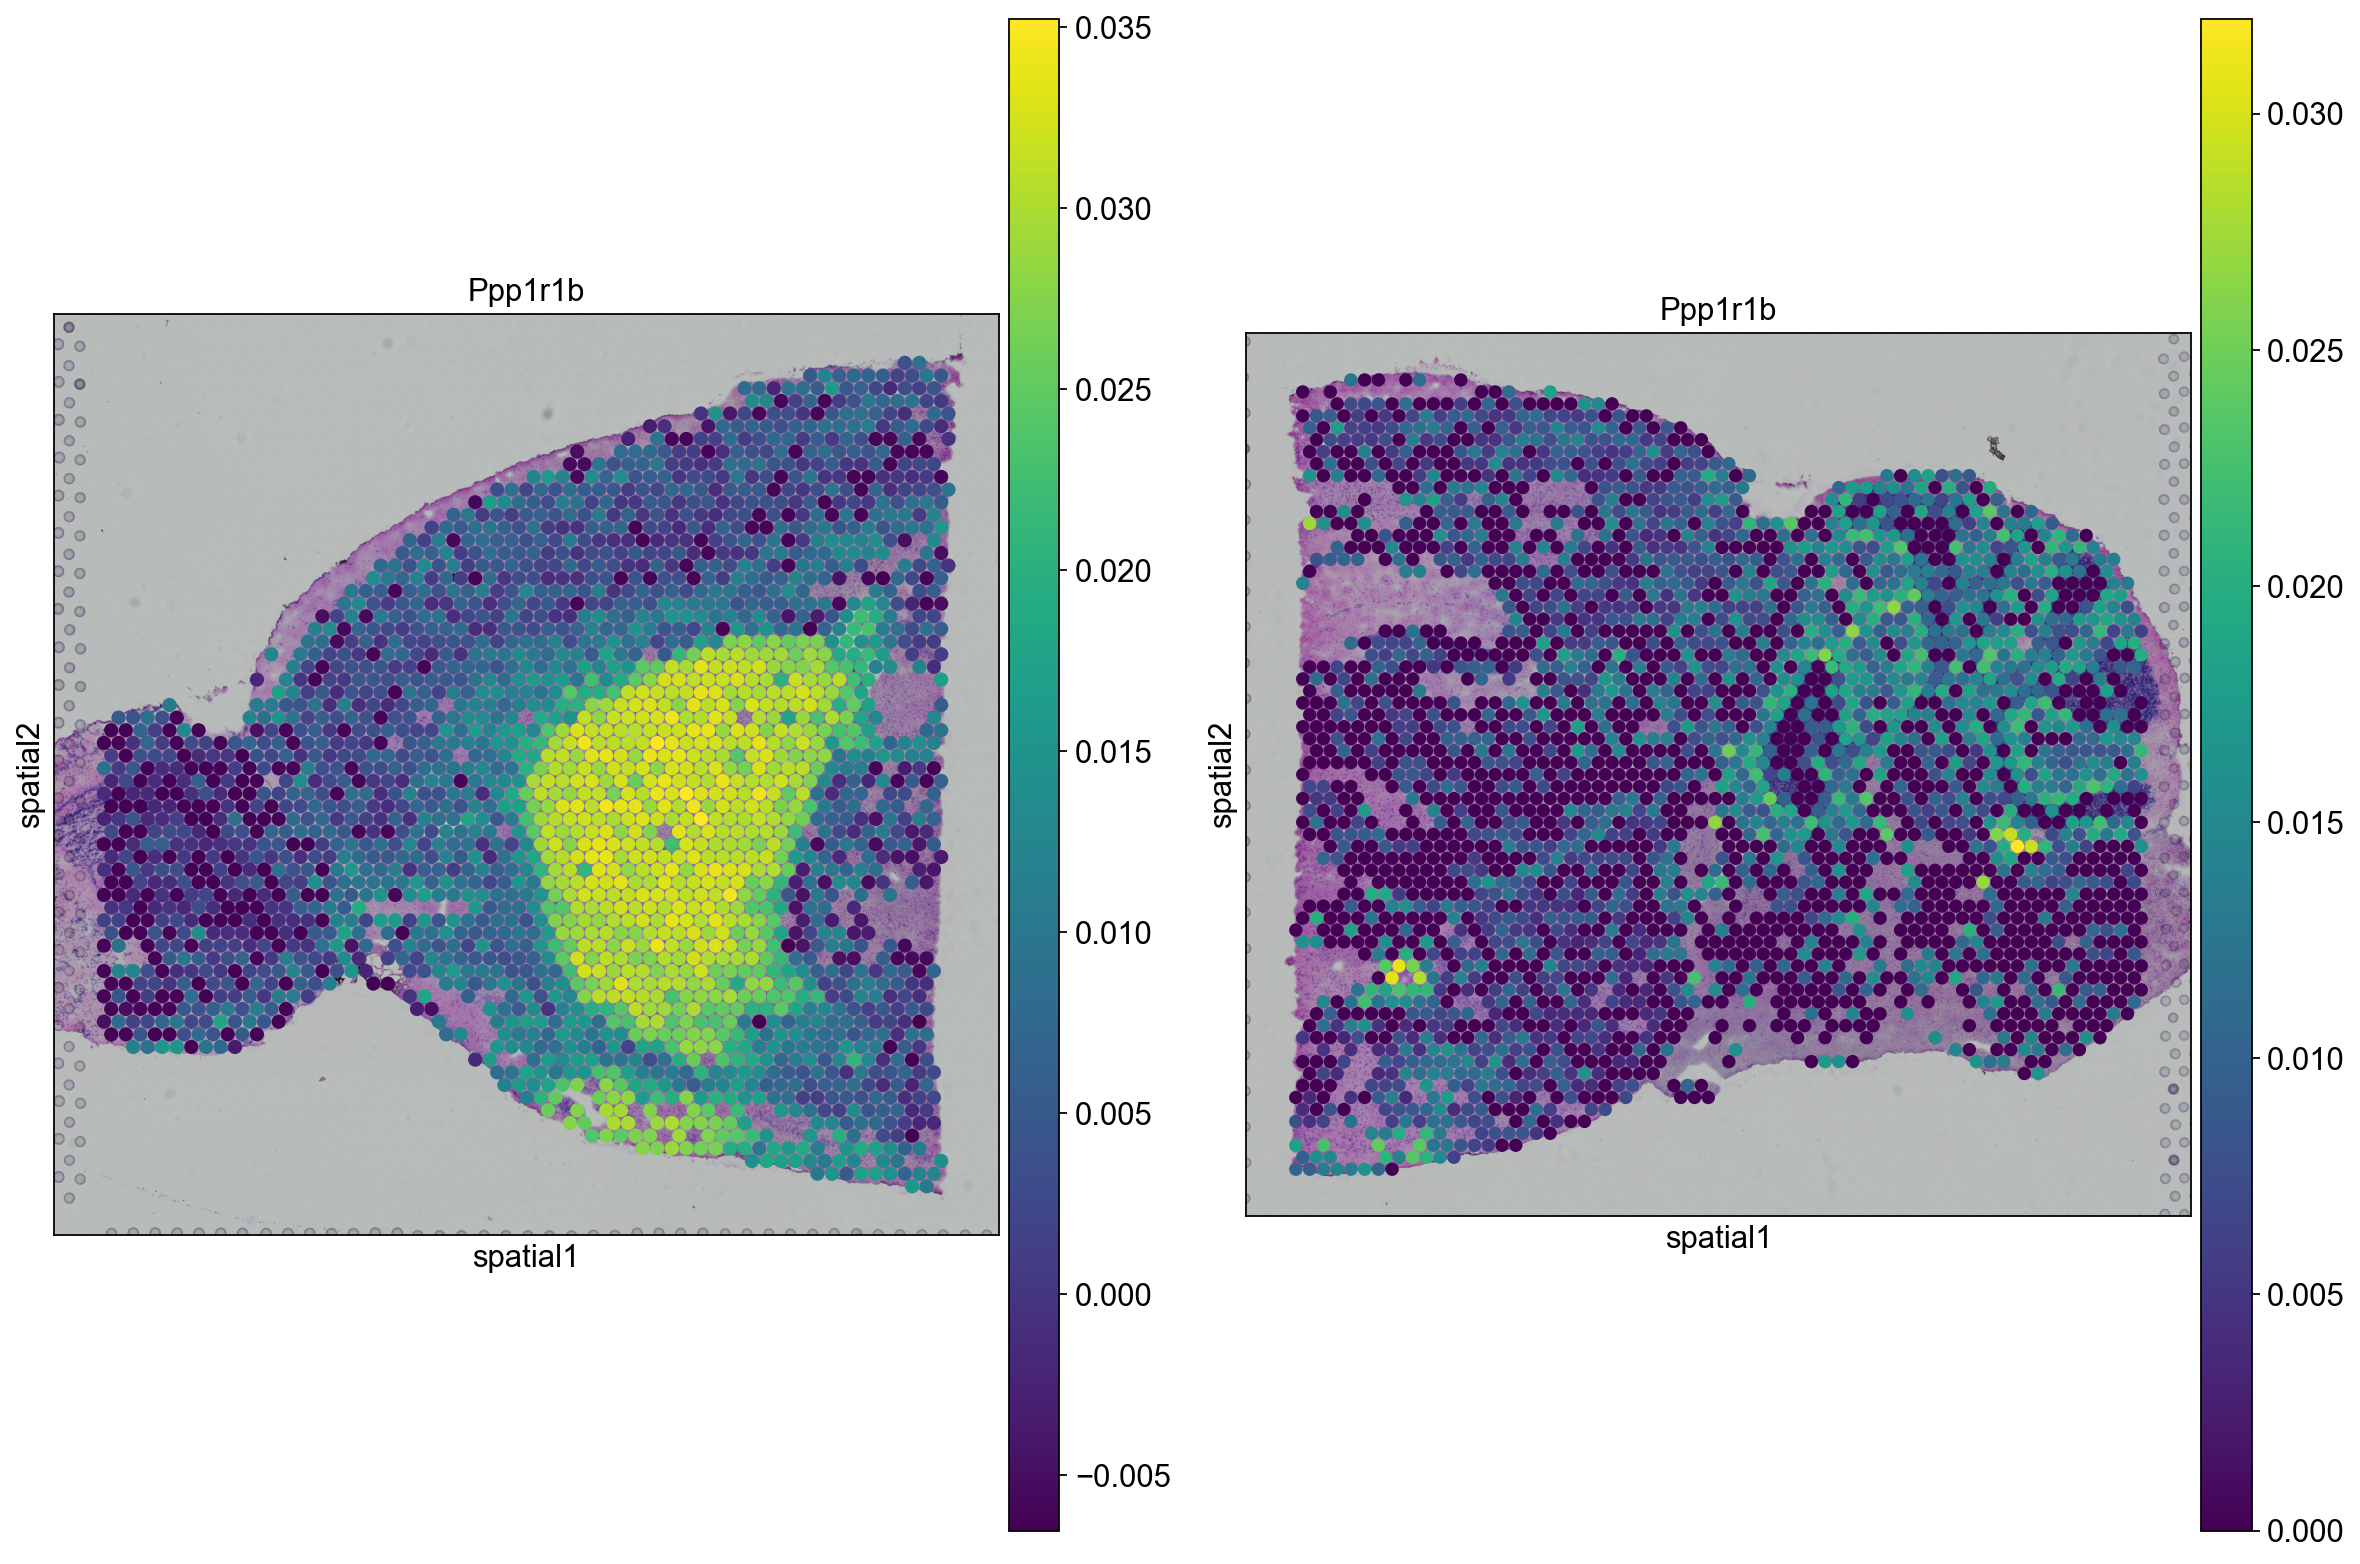

In [40]:
fig, axs= plt.subplots(1, 2, figsize= (15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]):
    ad= adata_spatial[adata_spatial.obs.library_id== library, :].copy()
    sc.pl.spatial(ad, img_key= "hires", library_id= library, color="Ppp1r1b", size=1.5, 
                 palette= [
                     v
                     for k, v in clusters_colors.items()
                     if k in ad.obs.clusters.unique().tolist()
                 ],
                 legend_loc= None, show= False, ax= axs[i],)
plt.tight_layout()